In [823]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt


from numpy import pi
from torch import sin, cos

In [824]:
X = torch.Tensor([
    [0., 0.],
    [0., 0.5],
    [0.25, 0.75],
    [1., 0.],
    [1., 0.]
])

k = 32
K = k**2
X = torch.rand(K, 2)
X, Y = torch.meshgrid((torch.linspace(0, 1, k), torch.linspace(0, 1, k)))
X, Y = X.reshape(-1, 1), Y.reshape(-1, 1)
X = torch.cat((X, Y), dim=1)

In [825]:
n = 3
N = 2*n**2 + n
nvec = torch.arange(1, n+1)

(0.0, 1.0)

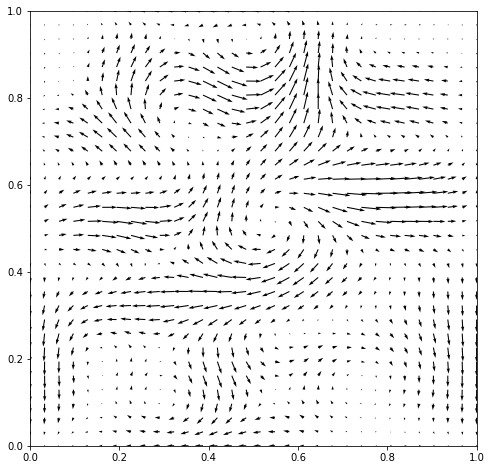

In [842]:
upsample = nn.Upsample(scale_factor=n, mode='nearest')
z = (X.view(K, 2, 1) * nvec)
S1 = torch.sin(pi * z)
S2 = torch.sin(2*pi*z)[:, (1, 0), :]
S3 = torch.cos(2*pi*z)[:, (1, 0), :]
T2 = upsample(S1) * S2.repeat(1, 1, n)
T3 = upsample(S1) * S3.repeat(1, 1, n)

B = torch.zeros(K, 2, 2*N)

B[:, 0, :n] = S1[:, 0, :]  # Type 1 x direction
B[:, 1, N:(N+n)] = S1[:, 1, :]  # Type 1  y-direction

B[:, 0, n:(n**2+n)] = T2[:, 0, :]  #Type 2 x-direction
B[:, 1, (N+n):(N + n**2 + n)] = T2[:, 1, :]  # Type 2 y-direction

B[:, 0, (n+n**2):N] = T3[:, 0, :]  # Type 3 x-direction
B[:, 1, (N+n+n**2):] = T3[:, 1, :]  # Type3 y-direction

c = torch.randn(2*N)
O = B @ c


plt.figure(figsize=(8, 8))
plt.quiver(X[:, 0], X[:, 1], O[:, 0], O[:, 1])
plt.xlim(0, 1)
plt.ylim(0, 1)

(0.0, 1.0)

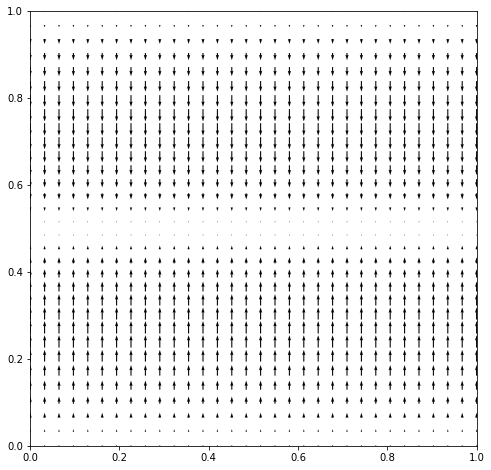

In [841]:
c = torch.zeros(2*N)
c[np.random.randint(2*N)] = 1.
O = B @ c


plt.figure(figsize=(8, 8))
plt.quiver(X[:, 0], X[:, 1], O[:, 0], O[:, 1])
plt.xlim(0, 1)
plt.ylim(0, 1)

# Derivative Map

In [833]:
X = torch.Tensor([
    [0., 0.],
    [0., 0.5],
    [0.25, 0.75],
    [1., 0.],
    [1., 0.]
])

k = 32
K = k**2
# K = X.shape[0]

n = 3
N = 2*n**2 + n



X, Y = torch.meshgrid((torch.linspace(0, 1, k), torch.linspace(0, 1, k)))
X, Y = X.reshape(-1, 1), Y.reshape(-1, 1)
X = torch.cat((X, Y), dim=1)

nvec = torch.arange(1, n+1)


D = torch.zeros(K, 2, 2, 2*N)

upsample = nn.Upsample(scale_factor=n, mode='nearest')
z = (X.view(K, 2, 1) * nvec)

S1 = torch.sin(pi * z)
S2 = torch.sin(2 * pi * z)[:, (1, 0), :]

C1 = torch.cos(pi * z)
C2 = torch.cos(2 * pi * z)[:, (1, 0), :]

D[:, 0, 0, :n] = nvec * pi * C1[:, 0, :]  # Type 1 x direction
D[:, 1, 1, N:(N+n)] = nvec * pi * C1[:, 1, :]  # Type 1  y-direction

T11 = upsample(nvec * pi * C1) * S2.repeat(1, 1, n)
T12 = upsample(S1) * (2 * pi * nvec * C2).repeat(1, 1, n)

D[:, 0, 0, n:(n + n**2)] = T11[:, 0, :]
D[:, 0, 1, n:(n + n**2)] = T12[:, 0, :]

D[:, 1, 1, (N+n):(N + n + n**2)] = T11[:, 1, :]
D[:, 1, 0, (N+n):(N + n + n**2)] = T12[:, 1, :]

T21 = upsample(nvec * pi * C1) * C2.repeat(1, 1, n)
T22 = upsample(S1) * (-2 * pi * nvec * S2).repeat(1, 1, n)

D[:, 0, 0, (n+n**2):N] = T21[:, 0, :]
D[:, 0, 1, (n+n**2):N] = T22[:, 0, :]

D[:, 1, 1, (N+n+n**2):] = T21[:, 1, :]
D[:, 1, 0, (N+n+n**2):] = T22[:, 1, :]

tensor(13)


(0.0, 1.0)

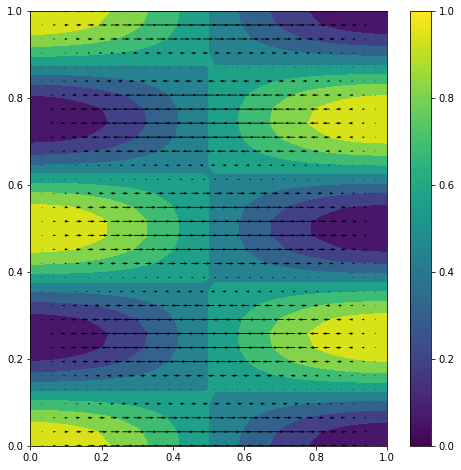

In [840]:
c = torch.zeros(2*N)
c[np.random.randint(2*N)] = 1.
print(c.argmax())
U = (B @ c)
O = D @ c

Xp = X.reshape(k, k, 2)

plt.figure(figsize=(8, 8))
plt.contourf(Xp[:, :, 0], Xp[:, :, 1], batch_trace(O).reshape(k, k))
plt.quiver(X[:, 0], X[:, 1], U[:, 0], U[:, 1])
plt.colorbar()

plt.xlim(0, 1)
plt.ylim(0, 1)

(0.0, 1.0)

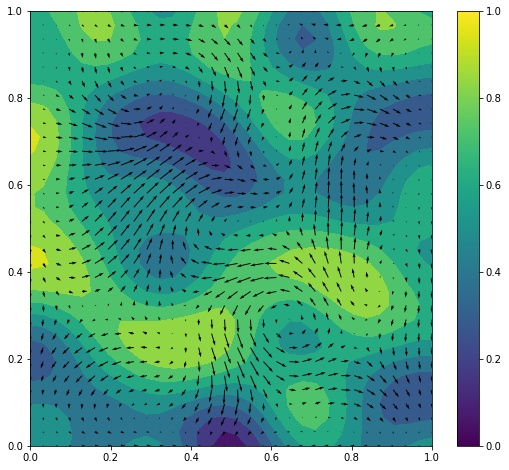

In [850]:
c = torch.randn(2*N)
U = (B @ c)
O = D @ c

Xp = X.reshape(k, k, 2)

plt.figure(figsize=(9, 8))
plt.contourf(Xp[:, :, 0], Xp[:, :, 1], batch_trace(O).reshape(k, k))
plt.quiver(X[:, 0], X[:, 1], U[:, 0], U[:, 1])
plt.colorbar()

plt.xlim(0, 1)
plt.ylim(0, 1)

In [835]:
def batch_determinant(B):
    assert B.dim() == 3, f"Dim.shape should be (K, 2, 2), got {B.shape}"
    return B[:, 0, 0] * B[:, 1, 1] - B[:, 1, 0] * B[:, 0, 1]


def batch_trace(B):
    assert B.dim() == 3, f"Dim.shape should be (K, 2, 2), got {B.shape}"
    return B[:, 0, 0] + B[:, 1, 1]
